In [1]:
# This code block provides functions to read and parse QD PPMS files.
# This version includes just the components necessary for magnetization measurements.
#
import logging
import csv
from math import copysign
from collections import namedtuple

# Returns +/-1 depending on the sign of x.
def sign(x):
    return copysign(1,x)

# Section aware importer of a PPMS data file
def readPPMSDataFile(file):
    rv = {}
    with open(file, newline="") as f:
        r = csv.reader(f,delimiter=',')
        hdr = []
        data = []
        section = None
        for l in r:
            if len(l) > 0:
                if l[0].lower() == '[Header]'.lower():
                    section = hdr
                elif l[0].lower() == '[Data]'.lower():
                    section = data
                elif len(l[0]) > 0 and l[0][0] == ';':
                    pass # ignore commented out lines
                elif section != None:
                    section.append(l)
                else:
                    logging.warning("No section yet defined for line: %s", l)
            else:
                logging.info("Ignoring empty line: %s", l)
        rv['header'] = hdr
        rv['data'] = data
    return rv

# Get the names of all the header variables
def getHeaders(fileData):
    rv = None
    if 'header' in fileData:
        rv = []
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            rv.append(l[0])
    return rv
   
# Get the value of a named header variable
def getHeaderValue(fileData, name):
    rv = None
    if 'header' in fileData:
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            if l[0].lower() == name.lower():
                if len(l) > 1:
                    val = ''.join(l[1:])
                else:
                    val = ''
                if rv is None:
                    rv = []
                rv.append(val)
    if (len(rv) > 1):
        return rv
    return rv[0]

# Get the names of the available data columns
def getDataColumns(fileData):
    rv = None
    if 'data' in fileData and len(fileData['data']) > 0:
        rv = fileData['data'][0]
    return rv

# Get the entries stored in one data column
def getDataColumn(fileData, name, prefixMatching=True):
    rv = None
    if 'data' in fileData:
        headers = None
        nameIndex = None
        headerName = None
        for l in fileData['data']:
            if headers is None:
                headers = l
                for i,h in enumerate(headers):
                    if ((prefixMatching and len(h) >= len(name) and h[0:len(name)].lower() == name.lower()) or
                       (not prefixMatching and h.lower() == name.lower())):
                        if nameIndex is None:
                            nameIndex = i
                            headerName = h
                            rv = []
                        else:
                            logging.warning("Ambiguous column selected: %s and %s both match %s", headerName, h, name)
            elif nameIndex != None:
                if len(l) > nameIndex:
                    try:
                        rv.append(float(l[nameIndex]))
                    except ValueError:
                        rv.append(l[nameIndex])
                else:
                    rv.append(None)
                    logging.warning("Unusually short line in data section: %s", l)
    return rv

def subRows(r1, r2, norm=True): # r1 - r2
    # Subtract each numerical element in two rows, element-by-element
    if norm:
        return map(lambda x,y: ((x-y)/(x+y+1e-11)) if (isinstance(x,(int,float)) and isinstance(y,(int,float))) else '', r1, r2)
    else:
        return map(lambda x,y: (x-y) if (isinstance(x,(int,float)) and isinstance(y,(int,float))) else '', r1, r2)

def rowNumsSignature(r):
    # returns a unique "signature" string showing the columns that are numeric and non-empty
    # used for sub-experiment binning.
    return ''.join(map(lambda x: '1' if isinstance(x,(int,float)) else '0', r))

# Named tuble containing all information in one row of a magnetization measurement
MagMeasurementsTuple = namedtuple('MagMeasurementsTuple', ["T","H","Mdc","Freq","Macr","Maci"])

def binSubMeasurements(fileData):
    rv = None
    # Most data files contain many logical experimental traces. This function uses a series
    # of heuristics in order to determine the break-points between sub-experiments present
    # in the input file. 
    cT = getDataColumn(fileData, "Temp")
    cH = getDataColumn(fileData, "Magnetic")
    cMdc = getDataColumn(fileData, "M-DC")
    cFreq = getDataColumn(fileData, "Frequency")
    cMacr = getDataColumn(fileData, "M' ")
    cMaci = getDataColumn(fileData, "M''")
    # sanity check
    if (len(cT) != len(cH) or len(cT) != len(cMdc) or len(cT) != len(cFreq) or
        len(cT) != len(cMacr) or len(cT) != len(cMaci)):
        logging.warning("Inconsistent or short column lengths: %i,%i,%i,%i,%i,%i", len(cT), len(cH), len(cMdc), len(cFreq), len(cMacr), len(cMaci))
        return rv
    rv = []
    if len(cT) < 3:
        # must be a single type of experiment
        return rv
    rows = [MagMeasurementsTuple(*x) for x in zip(*[cT,cH,cMdc,cFreq,cMacr,cMaci])] # index by row,col
    drow = MagMeasurementsTuple(*subRows(rows[1],rows[0]))
    i = 2
    h2 = []
    while i < len(rows):
        drow2 = MagMeasurementsTuple(*subRows(rows[i],rows[i-1]))
        if rowNumsSignature(rows[i]) != rowNumsSignature(rows[i-1]):
            # Heuristic 1: A change in the number or position of numeric columns necessarily implies a switch
            # to a new sub-experiment
            rv.append(i)
        elif rows[i].Freq != rows[i-1].Freq:
            # Heuristic 2: A change in the frequency of an AC measurement implies
            # switch to a new sub-experiment
            rv.append(i)
            pass
        elif sign(drow.T) != sign(drow2.T):
            # Heuristic 3: A change in the sign of a change of T *may* imply
            # a switch to a new sub-experiment, if that change is "not a small fluctuation"
            # Unfortunately, we need to see the whole sequence to know if it is a "small fluctuation"
            # so preserve these points for later incorporation
            h2.append(i-1)
        drow = drow2
        i += 1
    # Heuristic 3 is very "fuzzy" because of the existance of fluctuations, so we only add
    # entries from h2 if "far away" from the entries already in rv
    for i in h2:
        for j in rv:
            if abs(i-j) < 10:
                break
        else:
            rv.append(i)
    return sorted(rv),rows

def getSubMeasurements(fileData):
    # Splits the input data into individual sub-experiments
    bins = binSubMeasurements(fileData)
    rv = []
    pidx = 0
    for idx in bins[0]:
        rv.append(bins[1][pidx:idx])
        pidx = idx
    rv.append(bins[1][pidx:]) # don't forget final dataset
    return rv

def getMeasurementType(meas):
    # Attempt to classify the type of the passed measurement. Known types are:
    #
    # 1) "Mdc-T" Mdc vs T: Variable T, Constant H, Mdc, no Mac
    # 2) "Mac-T" Mac vs T: Variable T, Constant H, no Mdc, Mac
    # 3) "Mdc-H" Mdc vs H: Constant T, Variable H, Mdc, no Mac
    # 4) "Mac-H" Mac vs H: Constant T, Variable H, no Mdc, Mac
    #
    # Assumes the measurements have already been appropriately split into submeasurements
    #
    if isinstance(meas[0].Mdc,(int,float)) and not isinstance(meas[0].Macr,(int,float)):
        M = "Mdc"
    elif not isinstance(meas[0].Mdc,(int,float)) and isinstance(meas[0].Macr,(int,float)) and isinstance(meas[0].Maci,(int,float)):
        M = "Mac"
    elif isinstance(meas[0].Freq,(int,float)):
        M = "CenterAC"
    else:
        logging.warning("Could not identify AC or DC magnetization: %s", meas[0])
        M = "Unknown"
    maxT = max(map(lambda x: x.T, meas))
    minT = min(map(lambda x: x.T, meas))
    maxH = max(map(lambda x: x.H, meas))
    minH = min(map(lambda x: x.H, meas))
    if abs((maxT-minT)/(maxT+minT)) > 0.02:
        constT = False
    else:
        constT = True
    if abs((maxH-minH)/(maxH+minH)) > 0.02:
        constH = False
    else:
        constH = True
    if constT and not constH:
        TH = "H"
    elif not constT and constH:
        TH = "T"
    elif constT and constH:
        TH = "Center"
    else:
        logging.warning("Could not identify T vs H: constT=%s, constH=%s", constT, constH)
        TH = "Unknown"

    if M == "Unknown" or TH == "Unknown":
        return "Unknown"
    elif M == "CenterAC" and TH == "Center":
        return M
    elif M == "Mdc" and TH == "Center":
        return "CenterDC"
    else:
        return M + "-" + TH


In [2]:
# This code block implements automatic M0 determination for M vs T magnetization data
#
from scipy.stats import linregress
from math import log10
from collections import namedtuple

# Conduct a linear fit of 1/M vs T within a given temperature range
def linfitTrange(MT, Tmin, Tmax, M0):
    fitDataX = []
    fitDataY = []
    for r in MT:
        if (Tmin is None or r.T >= Tmin) and (Tmax is None or r.T <= Tmax):
            fitDataX.append(r.T)
            fitDataY.append(1/(r.Mdc-M0))
    return linregress(fitDataX,fitDataY)

# Results of a CW analysis
CWTuple = namedtuple("CWTuple", ["C","Th","M0"])

# Use a binary search to find the best M-0 value and do a Curie-Weiss analysis
def findM0CW(MT, Tmin=150, Tmax=None, Mlower=-1, Mhigher=1, tol=1e-6):
    Rlower = linfitTrange(MT, Tmin, Tmax, Mlower).rvalue
    Rhigher = linfitTrange(MT, Tmin, Tmax, Mhigher).rvalue
    while abs(Mhigher-Mlower) > tol:
        Mmid = (Mlower+Mhigher)/2
        Rmid = linfitTrange(MT, Tmin, Tmax, Mmid).rvalue
        if Rlower > Rhigher:
            Mhigher = Mmid
            Rhigher = Rmid
        else:
            Mlower = Mmid
            Rlower = Rmid
    M0 = (Mlower+Mhigher)/2
    M0 = round(M0,-1*int(log10(tol))) # truncate to sig figs
    digits = max(len(str(abs(round(M0/tol)))),3)
    CW = linfitTrange(MT, Tmin, Tmax, M0)
    C = 1.0/CW.slope # emu-K
    C = float('{:.{p}g}'.format(C, p=digits))
    Th = -1.0*CW.intercept/CW.slope # K
    Th = float('{:.{p}g}'.format(Th, p=digits))
    return CWTuple(C,Th,M0)


<IPython.core.display.Javascript object>


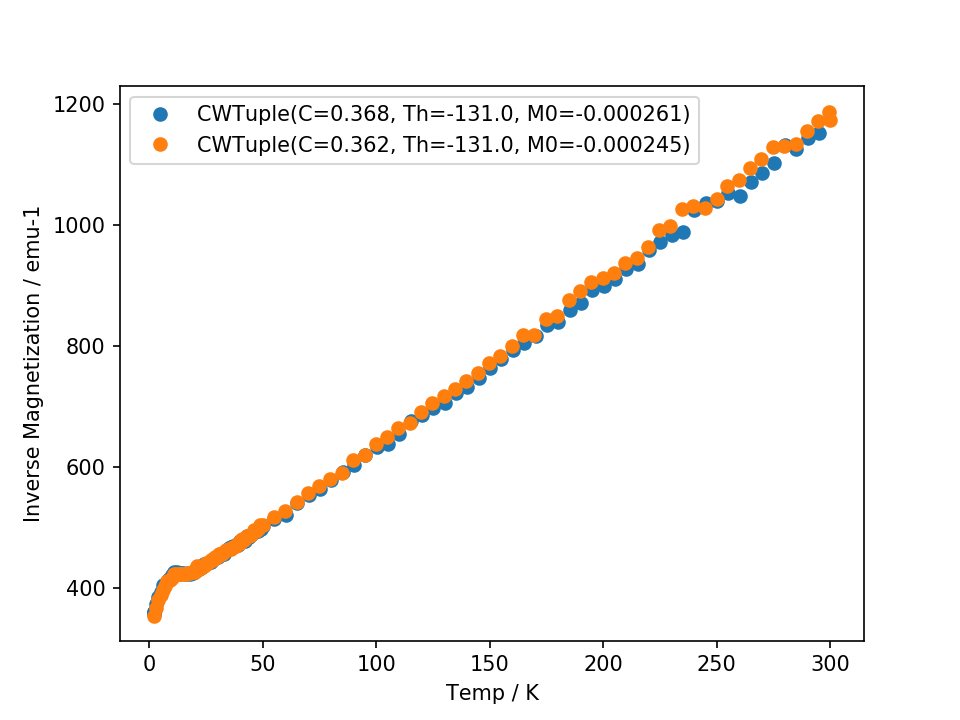

In [4]:
# Sample CW analysis of datasets from a single file
#
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("Inverse Magnetization / emu-1")
curFileData = readPPMSDataFile("140309 DCWb1133 Na1.7IrO3.dat")
Tmin = 100 # K
for meas in getSubMeasurements(curFileData):
    if getMeasurementType(meas) == "Mdc-T":
        CW = findM0CW(meas,Tmin=Tmin)
        x = []
        y = []
        for r in meas:
            x.append(r.T)
            y.append(1/(r.Mdc-CW.M0))
        plt.plot(x,y,'o',label=CW)
plt.legend()

<IPython.core.display.Javascript object>


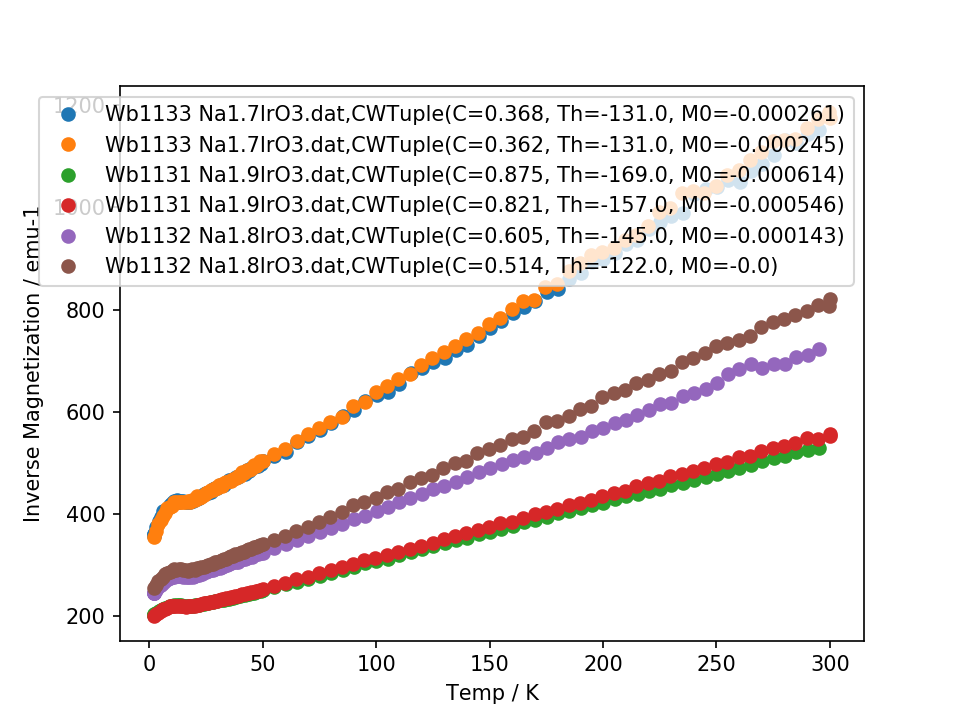

In [9]:
# Sample CW analysis of datasets from all files in a directory
#
from pathlib import Path
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("Inverse Magnetization / emu-1")
for file in Path('.').glob("*.dat"):
    curFileData = readPPMSDataFile(file)
    Tmin = 100 # K
    for meas in getSubMeasurements(curFileData):
        if getMeasurementType(meas) == "Mdc-T":
            CW = findM0CW(meas,Tmin=Tmin)
            x = []
            y = []
            for r in meas:
                x.append(r.T)
                y.append(1/(r.Mdc-CW.M0))
            plt.plot(x,y,'o',label=file.name[-20:] + "," + str(CW))
plt.legend()